Summary of the features we're keeping to run this iteration.  Here are our splits:
# 
| Feature Group | Features |
|--------------|----------|
| Quantified Metrics  | impressions, clicks, CTR (to create), AverageWinPrice (CPM) |
| ~~Channel & Location~~    | ~~channel, country, os, networkType, deviceType, AverageWinPrice (CPM)~~ |
| ~~Quantified with Date & Profit~~        | ~~impressions, clicks, date, CTR (to create), AverageWinPrice (CPM), rate~~ |
| ~~Advertiser & Product~~      | ~~advMaturity, publisherCategory, advertiserCategory, product, subProduct, campaign, AverageWinPrice (CPM), rate~~ |

In [1]:
!pip install numpy pandas matplotlib seaborn scikit-learn statsmodels openpyxl scipy


[notice] A new release of pip is available: 23.1.2 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


### Data Orientation

In [3]:
# split excel into multiple sheets
excel_file = 'data/raw/data.xlsx'
dir_name = 'data/raw'
xls = pd.ExcelFile(excel_file)

# load each sheet into a dataframe
for sheet_name in xls.sheet_names:
    df = pd.read_excel(xls, sheet_name=sheet_name)
    csv_file = f"{dir_name}/{sheet_name.replace(' ', '_')}.csv"
    df.to_csv(csv_file, index=False)
    print(f"Saved sheet: {sheet_name}")


Saved sheet: historical data
Saved sheet: data_to_predict


In [4]:
# let's take a look at the data
historical_df = pd.read_csv('data/raw/historical_data.csv')
historical_df.head()


,impressions,clicks,eDate,channel,country,os,networkType,deviceType,publisherCategory,advertiserCategory,product,subProduct,campaign,advPackage,advMaturity,AverageWinPrice (CPM),rate
0,9,0,2017-12-09,inr,AU,android,3g,mobile,game_arcade,entertainment,600775.0,NaN,301059092,NaN,low maturity,1.404217,0.140000
1,6,0,2017-12-09,inr,ES,android,3g,mobile,game_casual,game_educational,640029.0,com.mohitdev.minebuild,300208158,NaN,low maturity,0.575850,0.030000
2,57,0,2017-12-09,inr,FR,android,3g,mobile,game_word,game_action,618417.0,com.etermax.apalabrados.lite,300038580,NaN,low maturity,0.052181,0.017333
3,22,2,2017-12-09,inr,IT,android,3g,mobile,game_adventure,entertainment,631206.0,com.secg.robocraft,301068023,NaN,low maturity,0.265992,0.021000
4,3,0,2017-12-09,inr,IT,android,3g,mobile,game_arcade,entertainment,632417.0,com.craftpixelstudio.cubelands,300222537,NaN,low maturity,0.676667,0.035000


In [5]:
# let's take a statistical summary of the data
historical_df.describe(include='all')


,impressions,clicks,eDate,channel,country,os,networkType,deviceType,publisherCategory,advertiserCategory,product,subProduct,campaign,advPackage,advMaturity,AverageWinPrice (CPM),rate
count,304629.000000,304629.000000,304629,304629,304618,304629,304629,304629,253895,299908,2.400300e+05,251823,302951,76388,304628,304629.000000,304629.000000
unique,NaN,NaN,8,5,53,2,4,2,47,38,NaN,875,370,65,12,NaN,NaN
top,NaN,NaN,2017-12-11,mpb,ZA,android,3g,mobile,game_puzzle,entertainment,NaN,1075264954,300798390,com.p74.player,low maturity,NaN,NaN
freq,NaN,NaN,40739,172588,48404,281007,204345,295987,31406,139492,NaN,2779,7335,10025,187226,NaN,NaN
mean,88.306632,0.761815,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.370810e+08,NaN,NaN,NaN,NaN,0.207046,0.027231
std,1193.871334,12.364807,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.842803e+08,NaN,NaN,NaN,NaN,0.332051,0.027564
min,1.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.627600e+04,NaN,NaN,NaN,NaN,0.007190,0.003000
25%,2.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.872324e+06,NaN,NaN,NaN,NaN,0.050000,0.011000
50%,5.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.058059e+08,NaN,NaN,NaN,NaN,0.105240,0.020000
75%,21.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.219066e+09,NaN,NaN,NaN,NaN,0.207143,0.030000


In [6]:
data_to_predict_df = pd.read_csv('data/raw/data_to_predict.csv')
data_to_predict_df.head()

,sessionId,eDate,channel,country,os,networkType,deviceType,publisherCategory,advertiserCategory,product,subProduct,campaign,advPackage,advMaturity,rate
0,9705699729732200,2017-12-17,smt,BR,ios,unknown,mobile,NaN,education,130000706,319881193,301604736,com.kawecki.onemind,4+,0.010
1,12802690671750800,2017-12-17,smt,KH,android,3g,mobile,music & audio,entertainment,130167110,com.fundevs.app.mediaconverter,300988528,NaN,low maturity,0.008
2,21347409150256300,2017-12-17,smt,ID,ios,not_wifi,mobile,NaN,travel,130285027,com.alcaydevs.idlfree,300228923,com.go-jek.ios,4+,0.020
3,23329125091887800,2017-12-17,inr,RU,android,3g,mobile,social,music & audio,625569,drug.vokrug,301060338,com.p74.player,parental guidance,0.022
4,28266843791174100,2017-12-17,smt,DE,android,wifi,mobile,photography,NaN,130356465,com.photo.editor.cartoon,301011313,NaN,everyone,0.025


In [7]:
# dataframe dimensions
print(f"This dataframe has {historical_df.shape[0]} rows and {historical_df.shape[1]} columns.")
historical_df.info()

This dataframe has 304629 rows and 17 columns.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 304629 entries, 0 to 304628
Data columns (total 17 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   impressions            304629 non-null  int64  
 1   clicks                 304629 non-null  int64  
 2   eDate                  304629 non-null  object 
 3   channel                304629 non-null  object 
 4   country                304618 non-null  object 
 5   os                     304629 non-null  object 
 6   networkType            304629 non-null  object 
 7   deviceType             304629 non-null  object 
 8   publisherCategory      253895 non-null  object 
 9   advertiserCategory     299908 non-null  object 
 10  product                240030 non-null  float64
 11  subProduct             251823 non-null  object 
 12  campaign               302951 non-null  object 
 13  advPackage             76388 non-null   ob

In [8]:
# let's look at the distribution of our categorical variables
for column in historical_df.columns:
    if historical_df[column].dtype == 'object':
        print(f"Distribution of {column}:")
        print(historical_df[column].value_counts())
        print("\n")


Distribution of eDate:
eDate
2017-12-11    40739
2017-12-13    39743
2017-12-16    39000
2017-12-12    38743
2017-12-14    38546
2017-12-09    37791
2017-12-10    36090
2017-12-15    33977
Name: count, dtype: int64


Distribution of channel:
channel
mpb    172588
inr     72340
smt     49929
nxg      9495
rub       277
Name: count, dtype: int64


Distribution of country:
country
ZA    48404
JP    46055
ES    27456
RU    26017
PL    17768
FR    11087
IT     9515
BR     9087
MM     8869
AE     8582
US     5925
AU     5829
KR     5520
PA     4926
EG     4125
TN     4115
ID     3853
PT     3754
OM     3407
CL     3230
BH     2932
DE     2930
DZ     2799
GB     2793
MA     2558
NG     2534
HK     2471
KH     2435
VN     2382
KW     2341
TR     2064
NO     1942
MX     1675
RS     1665
NL     1586
IN     1536
SN     1271
DO     1245
SG     1121
PY      962
TH      916
HN      842
CA      738
MY      590
PH      577
AT      551
PK      512
HU      415
QA      247
TW      205
CR      130
SA     

### Visualizing our dataframes and eventual modeling



In [11]:
#create our CTR feature
historical_df['CTR'] = historical_df['clicks'] / historical_df['impressions']
quantified_metrics_cols = ['impressions', 'clicks', 'CTR', 'AverageWinPrice (CPM)']

/var/folders/nd/z10gkxp14_vbcbgjmpzd69200000gn/T/ipykernel_25516/1933353739.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(historical_df['impressions'], kde_kws={"color": "k", "lw": 2, "label": "KDE"})
/var/folders/nd/z10gkxp14_vbcbgjmpzd69200000gn/T/ipykernel_25516/1933353739.py:15: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed

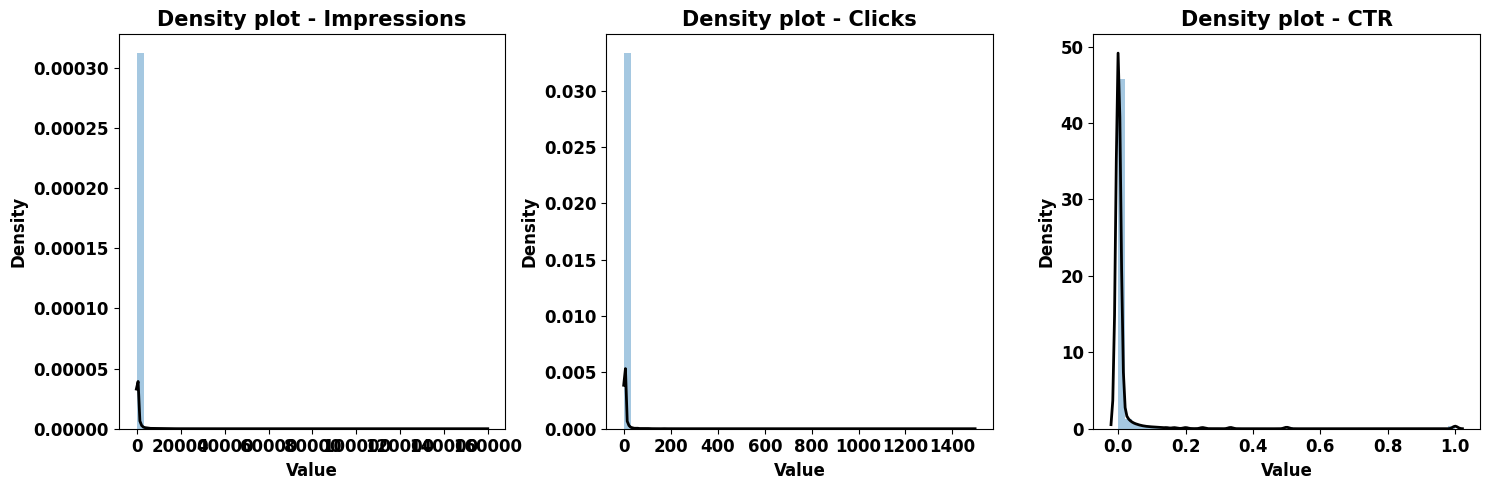

In [12]:
# Density plot of Number of Clicks
plt.figure(figsize=(15, 5))

# Density plot of Impressions
plt.subplot(1,3,1)
sns.distplot(historical_df['impressions'], kde_kws={"color": "k", "lw": 2, "label": "KDE"})
plt.xticks(fontsize=12, fontweight='bold')
plt.xlabel("Value", fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.ylabel("Density", fontsize=12, fontweight='bold')
plt.title("Density plot - Impressions", fontsize=15, fontweight='bold')

# Density plot of Clicks
plt.subplot(1,3,2)
sns.distplot(historical_df['clicks'], kde_kws={"color": "k", "lw": 2, "label": "KDE"})
plt.xticks(fontsize=12, fontweight='bold')
plt.xlabel("Value", fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.ylabel("Density", fontsize=12, fontweight='bold')
plt.title("Density plot - Clicks", fontsize=15, fontweight='bold')

# Density plot of CTR
plt.subplot(1,3,3)
sns.distplot(historical_df['CTR'], kde_kws={"color": "k", "lw": 2, "label": "KDE"})
plt.xticks(fontsize=12, fontweight='bold')
plt.xlabel("Value", fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.ylabel("Density", fontsize=12, fontweight='bold')
plt.title("Density plot - CTR", fontsize=15, fontweight='bold')

plt.tight_layout()
plt.show()

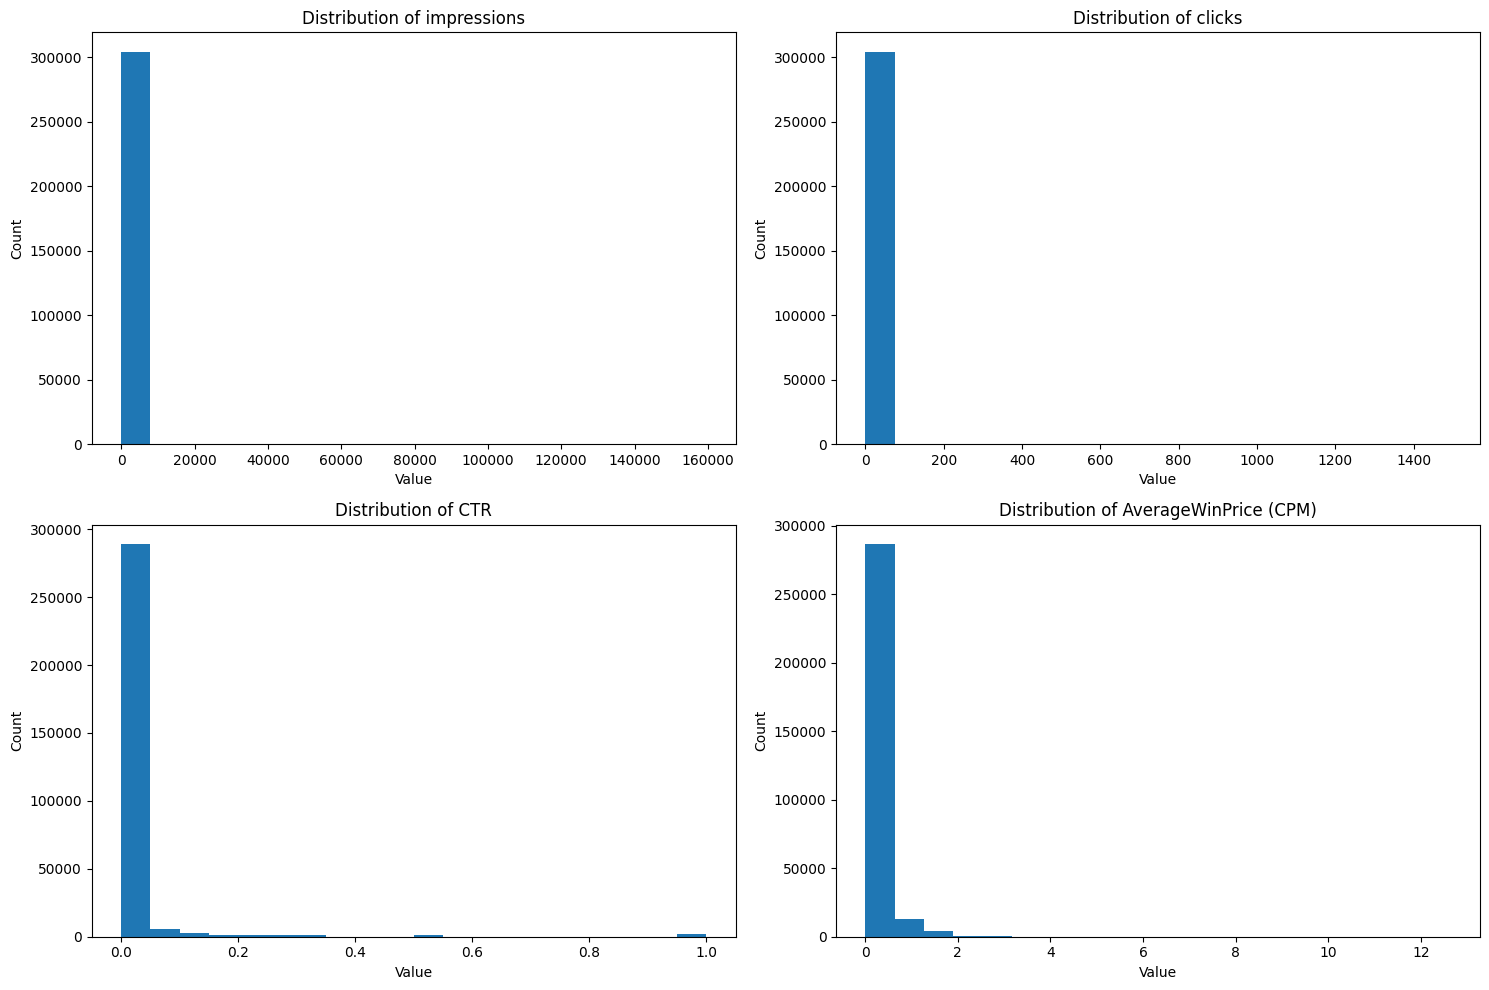

In [13]:
# Calculate the number of rows and columns needed for the subplots
n_cols = 2
n_rows = (len(quantified_metrics_cols) + n_cols - 1) // n_cols

fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axs = axs.flatten()  # Flatten the 2D array of axes to make indexing easier

for i, col in enumerate(quantified_metrics_cols):
    axs[i].hist(historical_df[col], bins=20)
    axs[i].set_ylabel("Count")
    axs[i].set_title(f"Distribution of {col}")
    axs[i].set_xlabel("Value")

# Remove any unused subplots
for i in range(len(quantified_metrics_cols), len(axs)):
    fig.delaxes(axs[i])

plt.tight_layout()
plt.show()

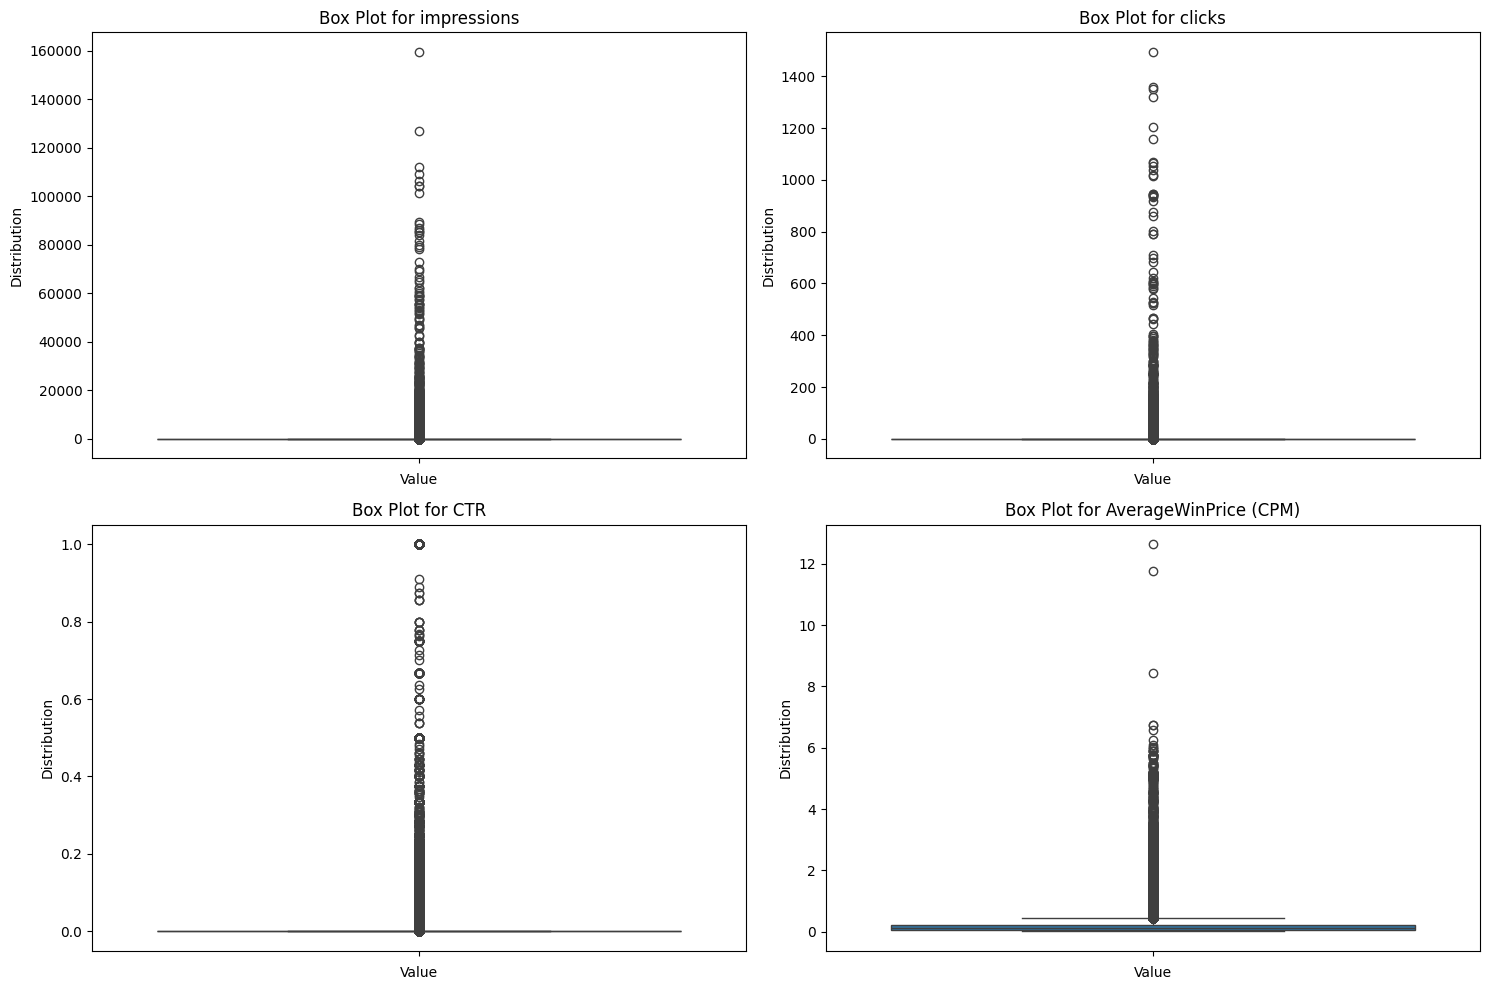

In [14]:
# Calculate the number of rows and columns needed for the subplots
n_cols = 2
n_rows = (len(quantified_metrics_cols) + n_cols - 1) // n_cols

fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axs = axs.flatten()  # Flatten the 2D array of axes to make indexing easier

for i, col in enumerate(quantified_metrics_cols):
    sns.boxplot(data=historical_df[col], ax=axs[i])
    axs[i].set_title(f'Box Plot for {col}')
    axs[i].set_xlabel('Value')
    axs[i].set_ylabel('Distribution')

# Remove any unused subplots
for i in range(len(historical_df.columns), len(axs)):
    fig.delaxes(axs[i])

plt.tight_layout()
plt.show()

### Preprocessing & EDA 

Removing outliers, missing values, etc.

Encoding of categorical variables to numbers

Declaring our target features.



In [15]:
# missing values summary
def missing_values_summary(df): 
    return pd.DataFrame(
        zip(
            df.columns,
            df.isna().any(),
            (df.isna().sum() / df.shape[0] * 100).round(2),
            df.dtypes,
            df.apply(lambda x: x.sample(n=1).iloc[0] if len(x) > 0 else None)),
        columns=['Column', 'Has Missing Values', '% Missing Values', 'Feature Type', 'Sample Value']
    )

missing_values_summary(historical_df)


,Column,Has Missing Values,% Missing Values,Feature Type,Sample Value
0,impressions,False,0.00,int64,4
1,clicks,False,0.00,int64,0
2,eDate,False,0.00,object,2017-12-09
3,channel,False,0.00,object,smt
4,country,True,0.00,object,JP
5,os,False,0.00,object,android
6,networkType,False,0.00,object,3g
7,deviceType,False,0.00,object,mobile
8,publisherCategory,True,16.65,object,entertainment
9,advertiserCategory,True,1.55,object,entertainment


In [16]:
# Let's drop the columns with more than 50% missing values
# remember that we process this on a COPY of our original dataframe
historical_eda_df = historical_df.drop(columns=['advPackage'])

# now let's convert the objects or floats to the correct type which is string
historical_eda_df['product'] = historical_eda_df['product'].round(0).astype(str)
historical_eda_df['campaign'] = historical_eda_df['campaign'].astype(str)

# Let's let's replace the missing values for the rest of the values less than 50% missing values with placeholder values
# this will be categorical variables so we will want to exclude these from our first couple of iterations since it's as to the product
historical_categorical_cols_imputed = ['publisherCategory', 'advertiserCategory', 'subProduct', 'campaign', 'product']
for col in historical_categorical_cols_imputed:
    historical_eda_df[col] = historical_eda_df[col].fillna('missing')


missing_values_summary(historical_eda_df)

,Column,Has Missing Values,% Missing Values,Feature Type,Sample Value
0,impressions,False,0.0,int64,1
1,clicks,False,0.0,int64,0
2,eDate,False,0.0,object,2017-12-10
3,channel,False,0.0,object,mpb
4,country,True,0.0,object,TH
5,os,False,0.0,object,android
6,networkType,False,0.0,object,3g
7,deviceType,False,0.0,object,mobile
8,publisherCategory,False,0.0,object,social
9,advertiserCategory,False,0.0,object,social


### Outlier Analysis

Looking at what we have above it's clear that we have a lot of outliers in our data.  We will need to clean this up for our modeling.  When we look at RATE it's a narrow range of numbers that's close to what we want.  But looking at impressive and win price we have outliers that are skewing our data.  We will need to clean this up for our modeling.

In [17]:
# here is where we will pass in our different tiny-dataframes into our created methods for visualization
#QUANTIFIED METRICS
historical_eda_df[quantified_metrics_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
impressions,304629.0,88.306632,1193.871334,1.00000,2.00,5.00000,21.000000,159617.00000
clicks,304629.0,0.761815,12.364807,0.00000,0.00,0.00000,0.000000,1495.00000
CTR,304629.0,0.015350,0.089528,0.00000,0.00,0.00000,0.000000,1.00000
AverageWinPrice (CPM),304629.0,0.207046,0.332051,0.00719,0.05,0.10524,0.207143,12.64182


Outliers based on Z-scores for impressions:
Number of outliers: 999
Percentage of outliers: 0.33%


Outliers based on Z-scores for clicks:
Number of outliers: 829
Percentage of outliers: 0.27%


Outliers based on Z-scores for CTR:
Number of outliers: 4191
Percentage of outliers: 1.38%


Outliers based on Z-scores for AverageWinPrice (CPM):
Number of outliers: 6426
Percentage of outliers: 2.11%




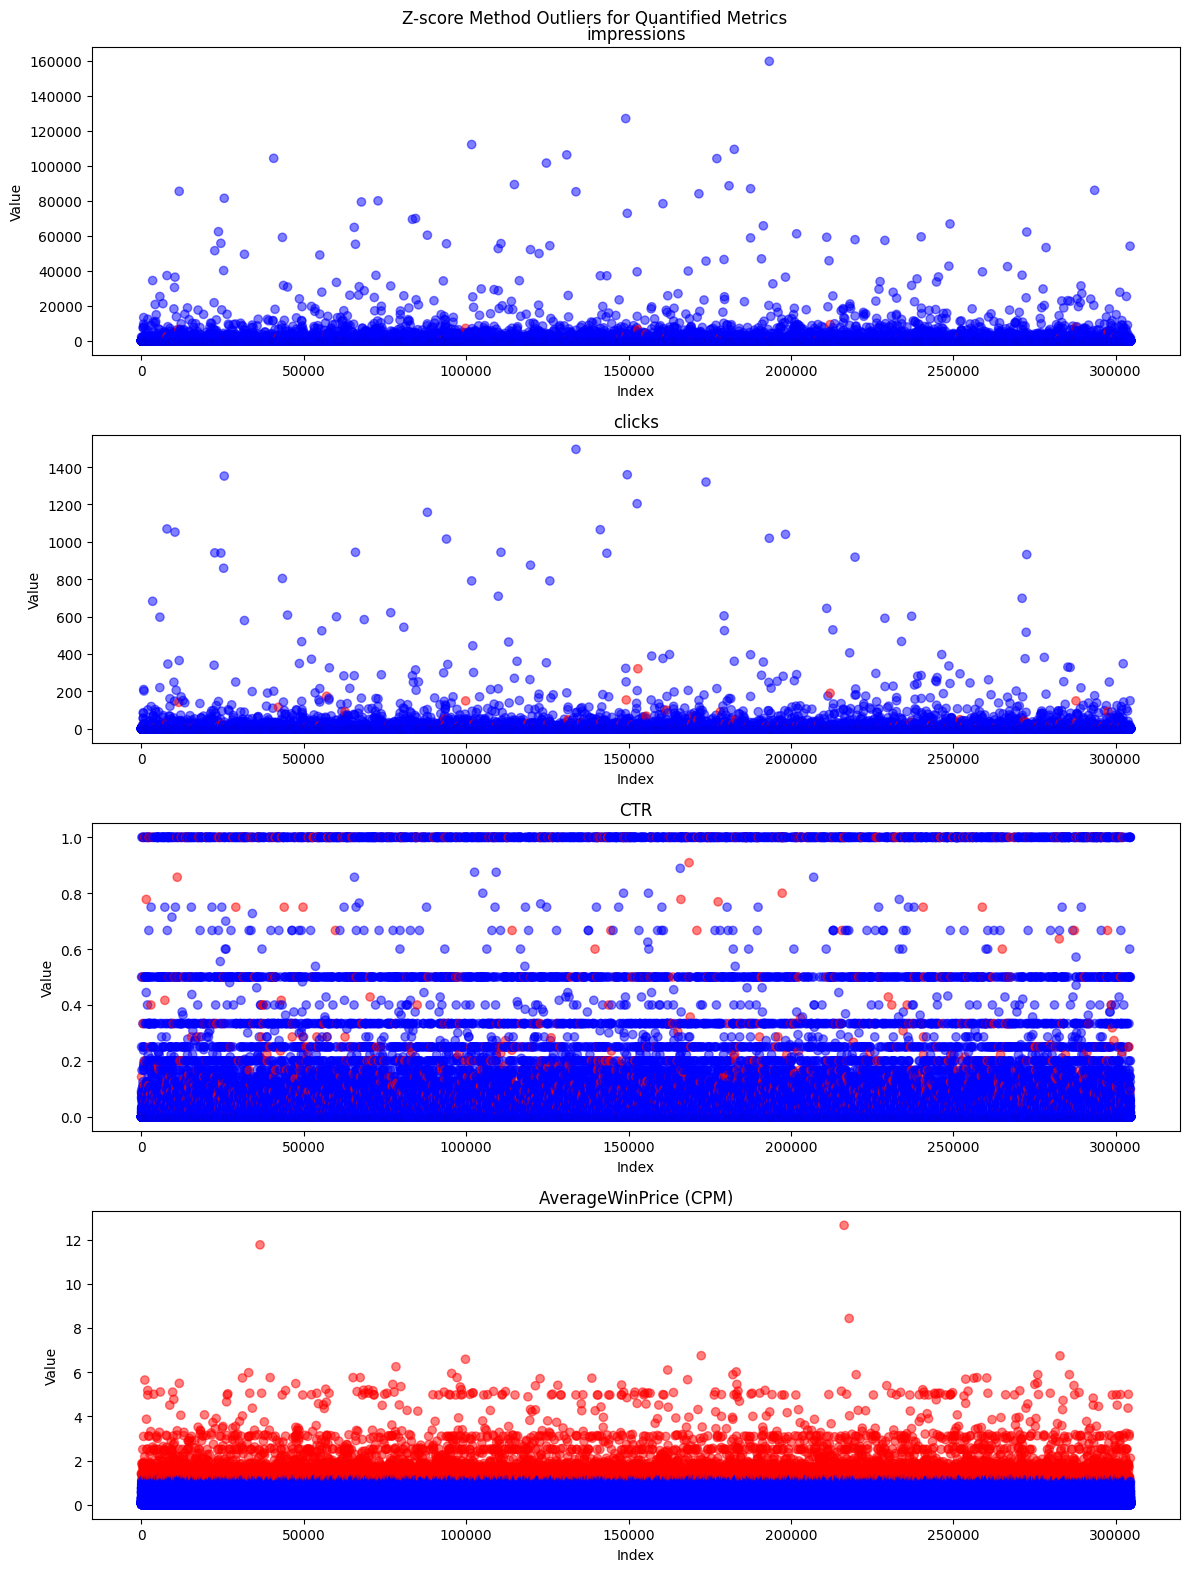

In [18]:
from scipy import stats

# Calculate Z-scores and identify outliers for each quantified metric
for col in quantified_metrics_cols:
    z_scores = stats.zscore(historical_eda_df[col])
    abs_z_scores = abs(z_scores)

    # Define a threshold for identifying outliers
    threshold = 3  # Commonly used threshold
    outliers_z = historical_eda_df[abs_z_scores > threshold]

    print(f"Outliers based on Z-scores for {col}:")
    print(f"Number of outliers: {len(outliers_z)}")
    print(f"Percentage of outliers: {(len(outliers_z) / len(historical_eda_df)) * 100:.2f}%")
    print("\n")

# Create a subplot for each quantified metric
fig, axs = plt.subplots(len(quantified_metrics_cols), 1, figsize=(12, 4*len(quantified_metrics_cols)))
fig.suptitle('Z-score Method Outliers for Quantified Metrics')

for idx, col in enumerate(quantified_metrics_cols):
  axs[idx].scatter(
      historical_eda_df.index, 
      historical_eda_df[col], 
      c=np.where(abs_z_scores > threshold, 'red', 'blue'),
      alpha=0.5
  )
  axs[idx].set_title(f'{col}')
  axs[idx].set_xlabel('Index')
  axs[idx].set_ylabel('Value')

plt.tight_layout()
plt.show()




Outliers based on IQR method for impressions:
Number of outliers: 43820
Percentage of outliers: 14.38%


Outliers based on IQR method for clicks:
Number of outliers: 42965
Percentage of outliers: 14.10%


Outliers based on IQR method for CTR:
Number of outliers: 42965
Percentage of outliers: 14.10%


Outliers based on IQR method for AverageWinPrice (CPM):
Number of outliers: 34003
Percentage of outliers: 11.16%




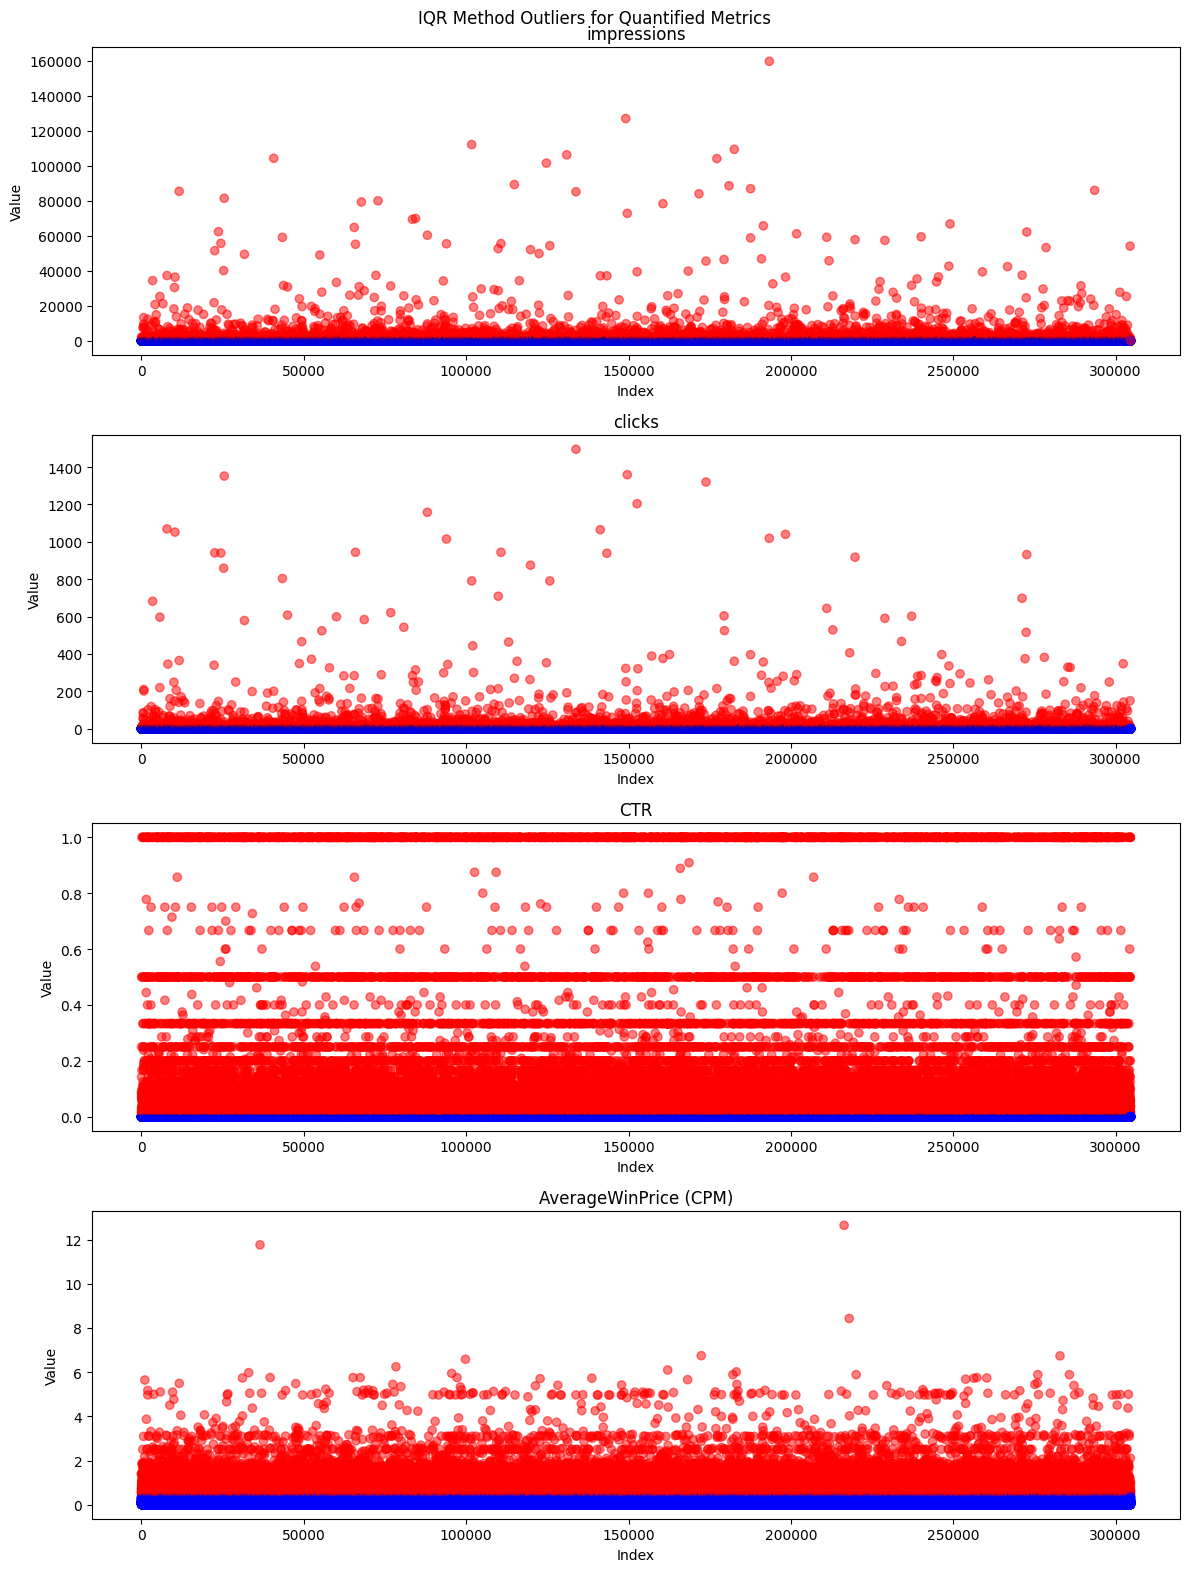

In [19]:
# Create a subplot for each quantified metric using IQR method
fig, axs = plt.subplots(len(quantified_metrics_cols), 1, figsize=(12, 4*len(quantified_metrics_cols)))
fig.suptitle('IQR Method Outliers for Quantified Metrics')

for idx, col in enumerate(quantified_metrics_cols):
    q1 = historical_eda_df[col].quantile(0.25)
    q3 = historical_eda_df[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    
    is_outlier = (historical_eda_df[col] < lower_bound) | (historical_eda_df[col] > upper_bound)
    
    axs[idx].scatter(
        historical_eda_df.index, 
        historical_eda_df[col], 
        c=np.where(is_outlier, 'red', 'blue'),
        alpha=0.5
    )
    axs[idx].set_title(f'{col}')
    axs[idx].set_xlabel('Index')
    axs[idx].set_ylabel('Value')
    
    outliers_iqr = historical_eda_df[is_outlier]
    print(f"Outliers based on IQR method for {col}:")
    print(f"Number of outliers: {len(outliers_iqr)}")
    print(f"Percentage of outliers: {(len(outliers_iqr) / len(historical_eda_df)) * 100:.2f}%")
    print("\n")

plt.tight_layout()
plt.show()


#### Ok we'll keep our outliers for now.  Let's see how the results come out and we'll move on to looking at the power of the correlations with this tiny-dataframe.

In [20]:
# Covariance Matrix to measure linear relationships
# positive values mean that as one variable increases, the other variable increases, this is a good thing
# we're looking for the highest positive values
historical_eda_df[quantified_metrics_cols].cov(numeric_only=True)


,impressions,clicks,CTR,AverageWinPrice (CPM)
impressions,1.425329e+06,10736.276451,-0.593717,-2.406123
clicks,1.073628e+04,152.888447,0.021270,0.087013
CTR,-5.937169e-01,0.021270,0.008015,0.002932
AverageWinPrice (CPM),-2.406123e+00,0.087013,0.002932,0.110258


In [21]:
# basically the same but capped at 1 or -1
historical_eda_df[quantified_metrics_cols].corr(numeric_only=True)


,impressions,clicks,CTR,AverageWinPrice (CPM)
impressions,1.000000,0.727292,-0.005555,-0.006070
clicks,0.727292,1.000000,0.019214,0.021193
CTR,-0.005555,0.019214,1.000000,0.098642
AverageWinPrice (CPM),-0.006070,0.021193,0.098642,1.000000


Looking here we see that these are good features for determining CPM:
- Impressions and CPM have a high negative correlation.  This means the more impressions we get the lower the price we pay.
- Impressions and clicks have a high positive correlation.  This means the more impressions we get the more clicks we get.
- CTR and CPM have a high negative correlation.  This means the higher the CTR the lower the price we pay.
- CTR and clicks have a high positive correlation.  This means the higher the CTR the more clicks we get.
- CPM and clicks have a high negative correlation.  This means the higher the price we pay the less clicks we get.

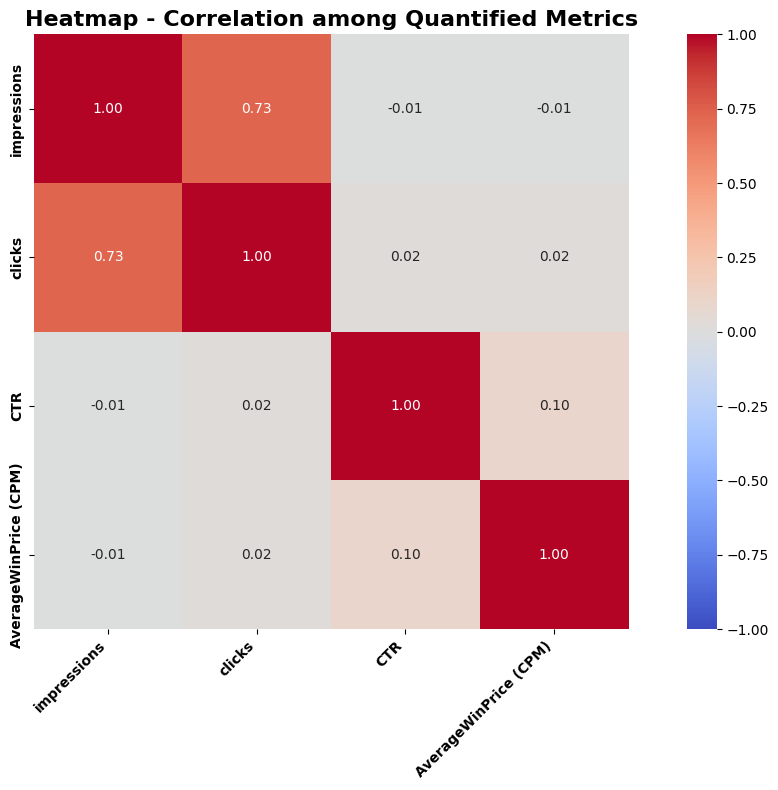

In [22]:
plt.figure(figsize=(12,8))
corr_var = historical_eda_df[quantified_metrics_cols].corr(numeric_only=True)
sns.heatmap(corr_var, annot=True, square=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1)
plt.xticks(fontsize=10, fontweight='bold', rotation=45, ha='right')
plt.yticks(fontsize=10, fontweight='bold')
plt.title("Heatmap - Correlation among Quantified Metrics", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

### Engineer our data & split data into training and testing sets

Feature scaling

In [28]:
import numpy as np
from sklearn.preprocessing import StandardScaler

quantized_metrics_to_scale = historical_eda_df[['impressions', 'clicks', 'CTR', 'AverageWinPrice (CPM)']]
scaler = StandardScaler()
# scale our data
# clicks with log transform + standard scaler

clicks_log = np.log1p(quantized_metrics_to_scale['clicks'])  # log1p handles ZERO values
clicks_scaled = scaler.fit_transform(clicks_log.values.reshape(-1, 1))

# impressions with log transform + standard scaler

impressions_log = np.log1p(quantized_metrics_to_scale['impressions'])
impressions_scaled = scaler.fit_transform(impressions_log.values.reshape(-1, 1))

# CTR with standard scaler

ctr_scaled = scaler.fit_transform(quantized_metrics_to_scale['CTR'].values.reshape(-1, 1))

# CPM with standard scaler

avg_win_price_log = np.log1p(quantized_metrics_to_scale['AverageWinPrice (CPM)'])
avg_win_price_scaled = scaler.fit_transform(avg_win_price_log.values.reshape(-1, 1))

# now let's put our scaled data back into our dataframe
quantized_metrics_to_scale['clicks_scaled'] = clicks_scaled
quantized_metrics_to_scale['impressions_scaled'] = impressions_scaled
quantized_metrics_to_scale['ctr_scaled'] = ctr_scaled
quantized_metrics_to_scale['avg_win_price_scaled'] = avg_win_price_scaled

# Suppress the SettingWithCopyWarning
pd.options.mode.chained_assignment = None  # default='warn'
quantized_metrics_to_scale.head()

,impressions,clicks,CTR,AverageWinPrice (CPM),clicks_scaled,impressions_scaled,ctr_scaled,avg_win_price_scaled
0,9,0,0.000000,1.404217,-0.328112,0.031764,-0.171459,3.699004
1,6,0,0.000000,0.575850,-0.328112,-0.200314,-0.171459,1.504039
2,57,0,0.000000,0.052181,-0.328112,1.175548,-0.171459,-0.594801
3,22,2,0.090909,0.265992,1.912147,0.573712,0.843973,0.366421
4,3,0,0.000000,0.676667,-0.328112,-0.564438,-0.171459,1.826261


In [33]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Define features and labels
X = quantized_metrics_to_scale[['clicks', 'impressions']]
y_ctr = quantized_metrics_to_scale['CTR']
y_avg_win_price = quantized_metrics_to_scale['AverageWinPrice (CPM)']

# Split the data
X_train, X_test, y_ctr_train, y_ctr_test, y_avg_win_price_train, y_avg_win_price_test = train_test_split(
    X, y_ctr, y_avg_win_price, test_size=0.2, random_state=42
)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(np.log1p(X_train))
X_test_scaled = scaler.transform(np.log1p(X_test))

# Scale the target variables
ctr_scaler = StandardScaler()
y_ctr_train_scaled = ctr_scaler.fit_transform(y_ctr_train.values.reshape(-1, 1)).ravel()
y_ctr_test_scaled = ctr_scaler.transform(y_ctr_test.values.reshape(-1, 1)).ravel()

avg_win_price_scaler = StandardScaler()
y_avg_win_price_train_scaled = avg_win_price_scaler.fit_transform(np.log1p(y_avg_win_price_train.values.reshape(-1, 1))).ravel()
y_avg_win_price_test_scaled = avg_win_price_scaler.transform(np.log1p(y_avg_win_price_test.values.reshape(-1, 1))).ravel()


### Modeling

In [34]:
# Train CTR model
ctr_model = LinearRegression()
ctr_model.fit(X_train_scaled, y_ctr_train_scaled)

# Train avg win price model
avg_win_price_model = LinearRegression()
avg_win_price_model.fit(X_train_scaled, y_avg_win_price_train_scaled)

# Make predictions
ctr_predictions = ctr_model.predict(X_test_scaled)
avg_win_price_predictions = avg_win_price_model.predict(X_test_scaled)


### Evaluation

In [35]:
# evaluate the models
ctr_mse = mean_squared_error(y_ctr_test, ctr_predictions)
ctr_r2 = r2_score(y_ctr_test, ctr_predictions)

print(f"CTR MSE: {ctr_mse}")
print(f"CTR R2: {ctr_r2}")

avg_win_price_mse = mean_squared_error(y_avg_win_price_test, avg_win_price_predictions)
avg_win_price_r2 = r2_score(y_avg_win_price_test, avg_win_price_predictions)

print(f"Avg Win Price MSE: {avg_win_price_mse}")
print(f"Avg Win Price R2: {avg_win_price_r2}")

CTR MSE: 0.10331358029104483
CTR R2: -12.307692822748844
Avg Win Price MSE: 0.16231652817200998
Avg Win Price R2: -0.5026555843389855


### Optimization

Let's give a non-linear gradient boosting model a shot.
Benefit with Gradient Boosting:
- Non-linear relationships
- Reduces overfitting
- Better performance on complex datasets
- Learns from weak learners


In [37]:
from sklearn.ensemble import GradientBoostingRegressor

grad_X_cpm_train, grad_X_cpm_test, grad_y_cpm_train, grad_y_cpm_test = train_test_split(X, y_avg_win_price, test_size=0.2, random_state=42)
# Scale the features for Gradient Boosting model
scaler_grad = StandardScaler()
grad_X_cpm_train_scaled = scaler_grad.fit_transform(grad_X_cpm_train)
grad_X_cpm_test_scaled = scaler_grad.transform(grad_X_cpm_test)

# Scale the target variable (CPM AvgWinning) for Gradient Boosting model
scaler_grad_y = StandardScaler()
grad_y_cpm_train_scaled = scaler_grad_y.fit_transform(grad_y_cpm_train.values.reshape(-1, 1)).flatten()
grad_y_cpm_test_scaled = scaler_grad_y.transform(grad_y_cpm_test.values.reshape(-1, 1)).flatten()

# model training
gbm_cpm_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
gbm_cpm_model.fit(grad_X_cpm_train, grad_y_cpm_train)

# model predictions
gbm_cpm_predictions = gbm_cpm_model.predict(grad_X_cpm_test)

# evaluation
gbm_cpm_mse = mean_squared_error(grad_y_cpm_test, gbm_cpm_predictions)
gbm_cpm_r2 = r2_score(grad_y_cpm_test, gbm_cpm_predictions)

print(f"GBM CPM AvgWinning MSE: {gbm_cpm_mse}")
print(f"GBM CPM AvgWinning R2: {gbm_cpm_r2}")

GBM CPM AvgWinning MSE: 0.10454375600841555
GBM CPM AvgWinning R2: 0.03217952883181918
